In [2]:
# import plotly.graph_objects as go
# import plotly.express as px
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import ConvexHull

In [107]:
MYELOID = "myeloid.csv"
CARDIAC = "cardiac.csv"
ERBB = "erbb.csv"
TUMOUR = "tumour.csv"

ALL_MODELS = [MYELOID, CARDIAC, ERBB, TUMOUR]

ATT_COLORS_COL = "Attractor colors"

ONE_STEP_COL = "One-step (ms)"
ONE_STEP_PLT_COLOUR = "blue"
ONE_STEP_MARKER = 'x'

PERMANENT_COL = "Permanent (ms)"
PERMANENT_PLT_COLOUR = "red"
PERMANENT_MARKER = '.'

TEMPORARY_COL = "Temporary (ms)"
TEMPORARY_PLT_COLOUR = "#8c6b49"
TEMPORARY_MARKER = '^'

ALL_METHOD_COLS = [ONE_STEP_COL, PERMANENT_COL, TEMPORARY_COL]
ALL_METHODS_COLOURS = [ONE_STEP_PLT_COLOUR, PERMANENT_PLT_COLOUR, TEMPORARY_PLT_COLOUR]
ALL_METHODS_MARKERS = [ONE_STEP_MARKER, PERMANENT_MARKER, TEMPORARY_MARKER]

# This isn't currently "settable", as most of the code has this base hard-coded
LOG_BASE = 10

In [4]:
def generate_scatter(model_path, method):
    full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, method]]
    cleansed_df = full_results_df[full_results_df > 0].dropna()
    points_np = np.array(cleansed_df.to_numpy())
    return points_np[:, 0], points_np[:, 1]

In [118]:
def generate_log_scatter(model_path, method):
    full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, method]]
    cleansed_df = full_results_df[full_results_df > 0].dropna()
    points_np = np.log10(np.array(cleansed_df.to_numpy()))
    # points_np = np.array(cleansed_df.to_numpy())
    return points_np[:, 0], points_np[:, 1]

In [110]:
def generate_labelled_log_scatter(model_path, method):
    full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, method]]
    cleansed_df = full_results_df[full_results_df > 0].dropna()
    normalized_df =  cleansed_df.applymap(math.log10)
    normalized_df['label'] = method.removesuffix(" (ms)")
    return normalized_df.rename(columns={method: 'Time (ms)'})

In [111]:
def generate_hull(model_path, method):
    full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, method]]
    cleansed_df = full_results_df[full_results_df > 0].dropna()
    points_np = np.log10(np.array(cleansed_df.to_numpy()))
    hull = points_np[ConvexHull(points_np).vertices]
    bases = np.full_like(hull, LOG_BASE)
    hull_original_coors = np.power(bases, hull)
    hull_full_shape = np.vstack((hull_original_coors, hull_original_coors[0]))
    return hull_full_shape[:, 0], hull_full_shape[:, 1]
    # return np.concatenate((hull_original, hull_original[:1]))
    # return np.concatenate((hull_original, hull_original[0].reshape(1, -1)))

In [112]:
def generate_hull_plot(model_path, method, method_colour, method_marker, x_lim, y_lim, axe):
    x, y = generate_hull(model_path, method)
    x_s, y_s = generate_scatter(model_path, method)

    axe.set_title(method.removesuffix(" (ms)"))

    axe.set_xscale('log')
    axe.set_xlim(1, x_lim)
    axe.set_xlabel('Attractor colours')

    axe.set_yscale('log')
    axe.set_ylim(1, y_lim)
    axe.set_ylabel('Time (ms)')

    axe.fill(x, y, facecolor='None', edgecolor=method_colour, linewidth=1, alpha=0.4)
    axe.fill(x, y, facecolor=method_colour, alpha=0.1)
    axe.scatter(x_s, y_s, marker=method_marker, facecolor=method_colour)

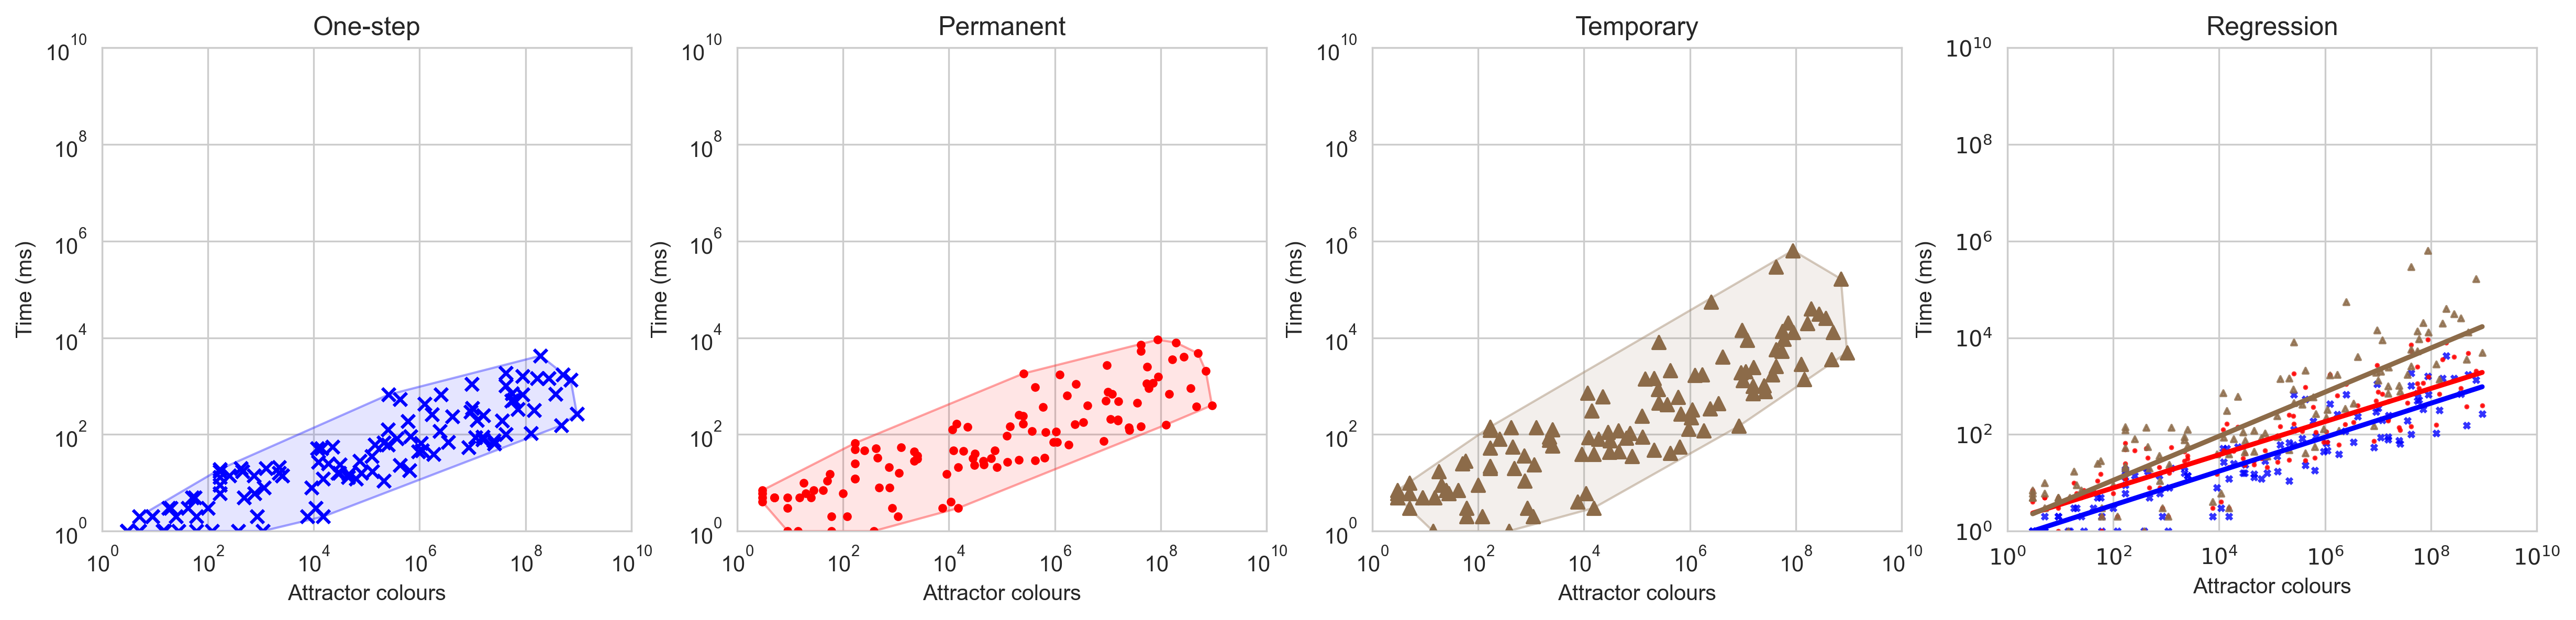

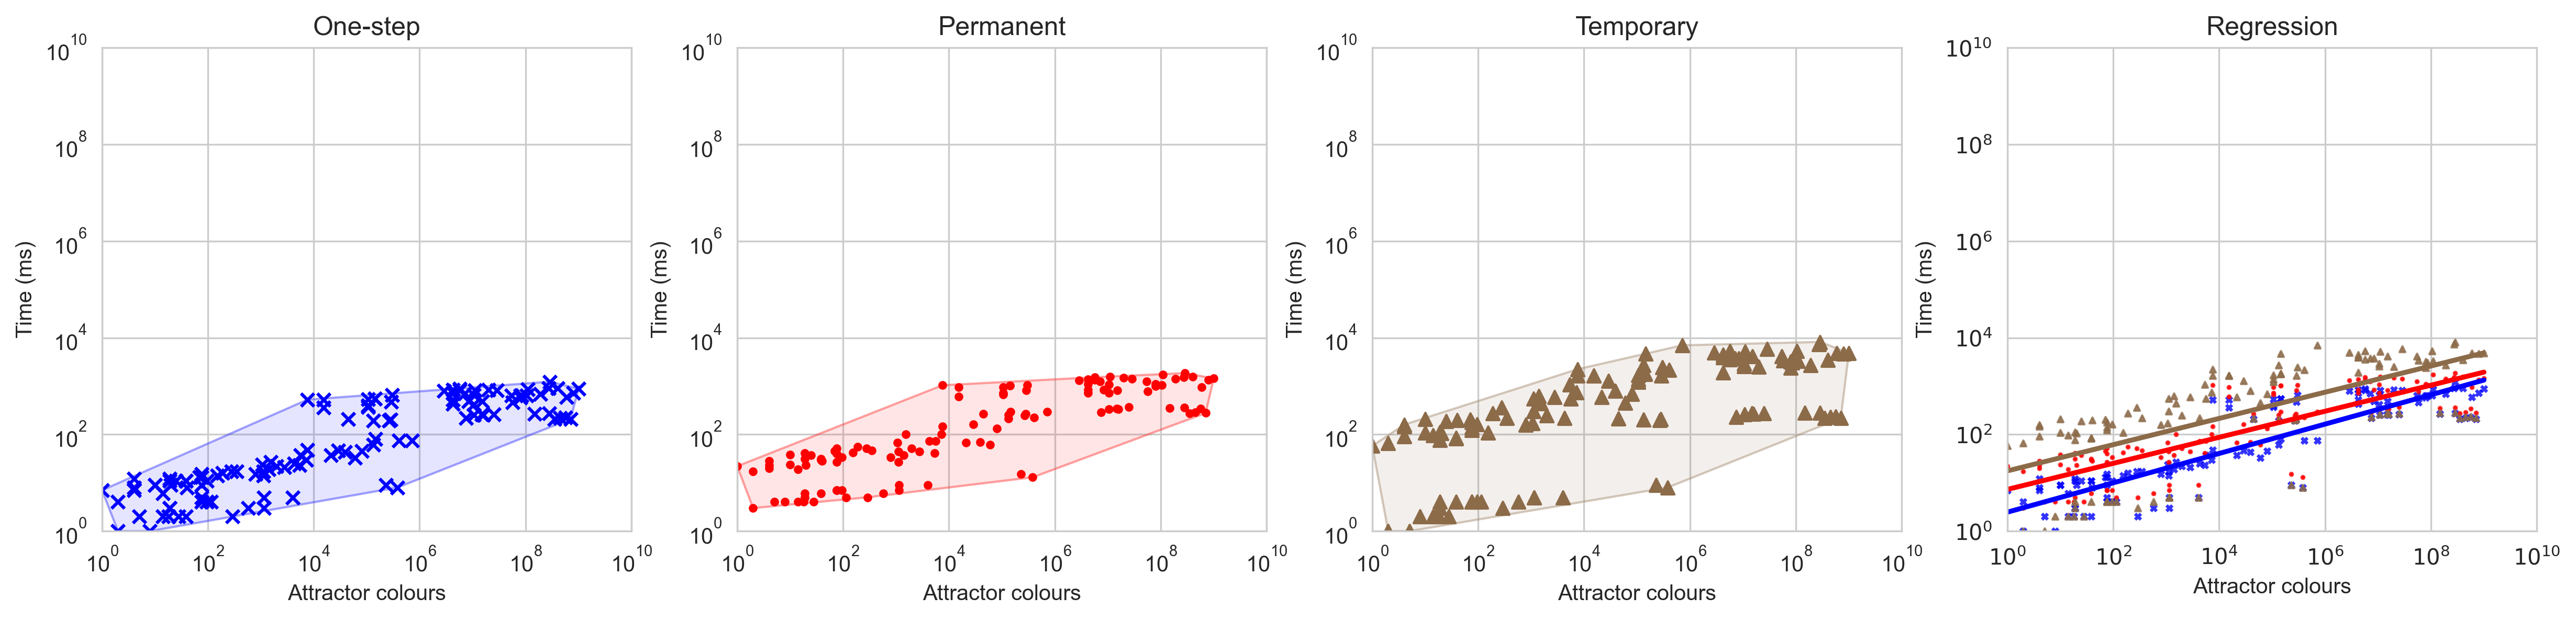

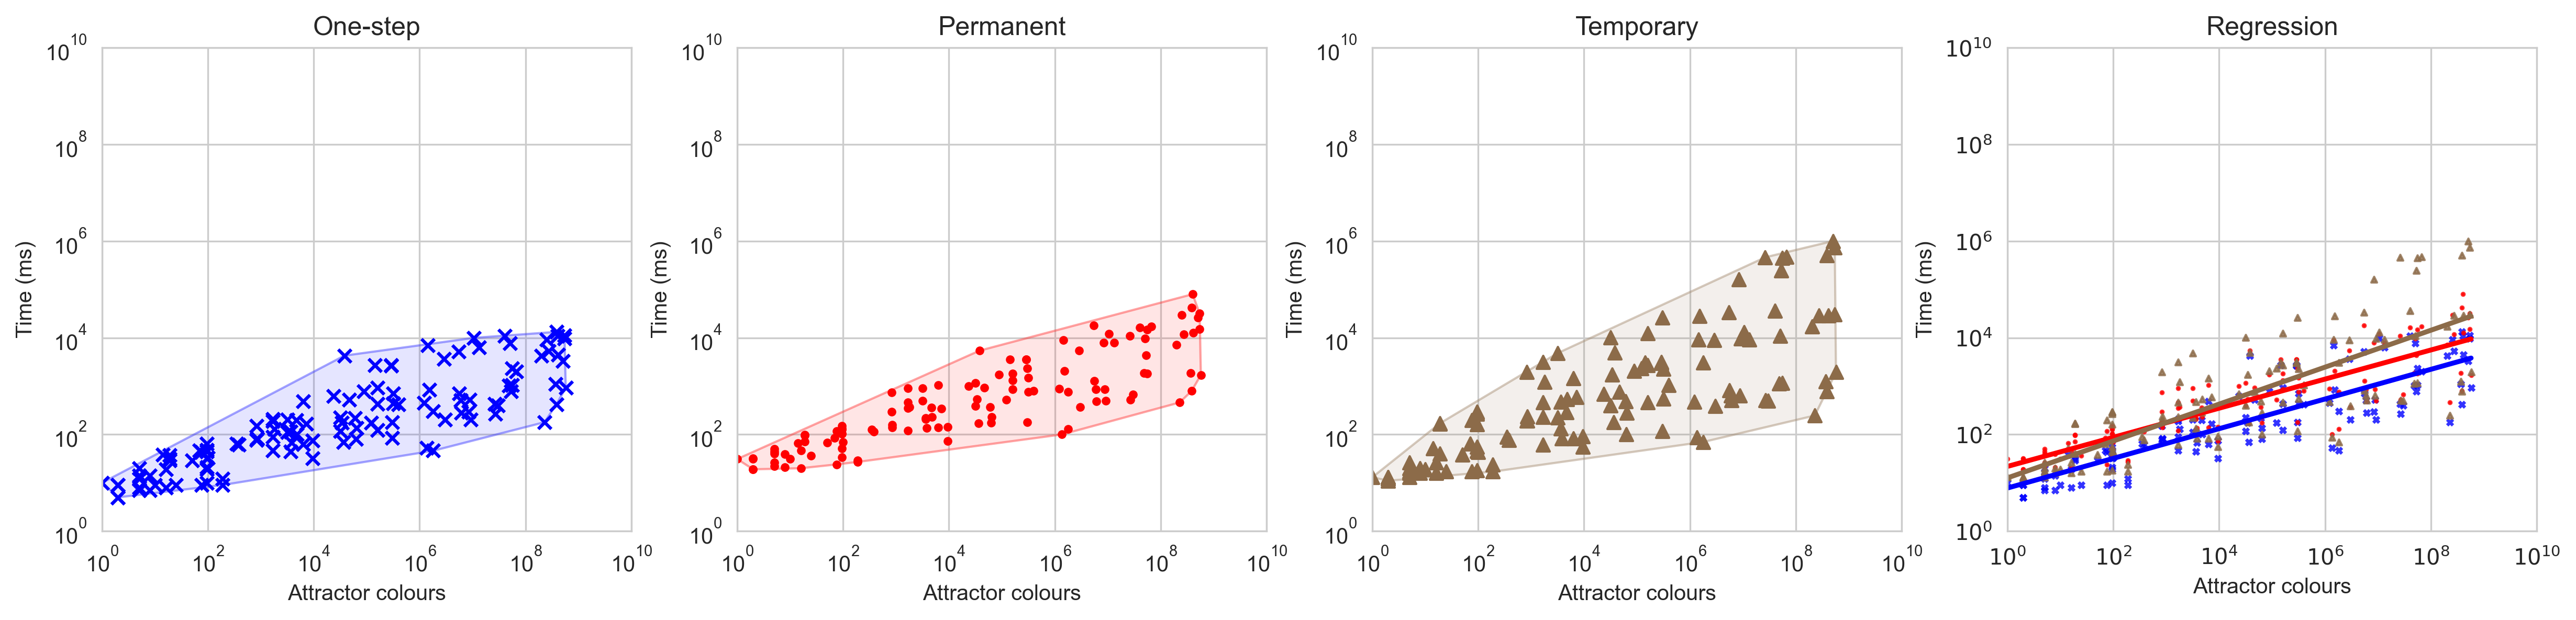

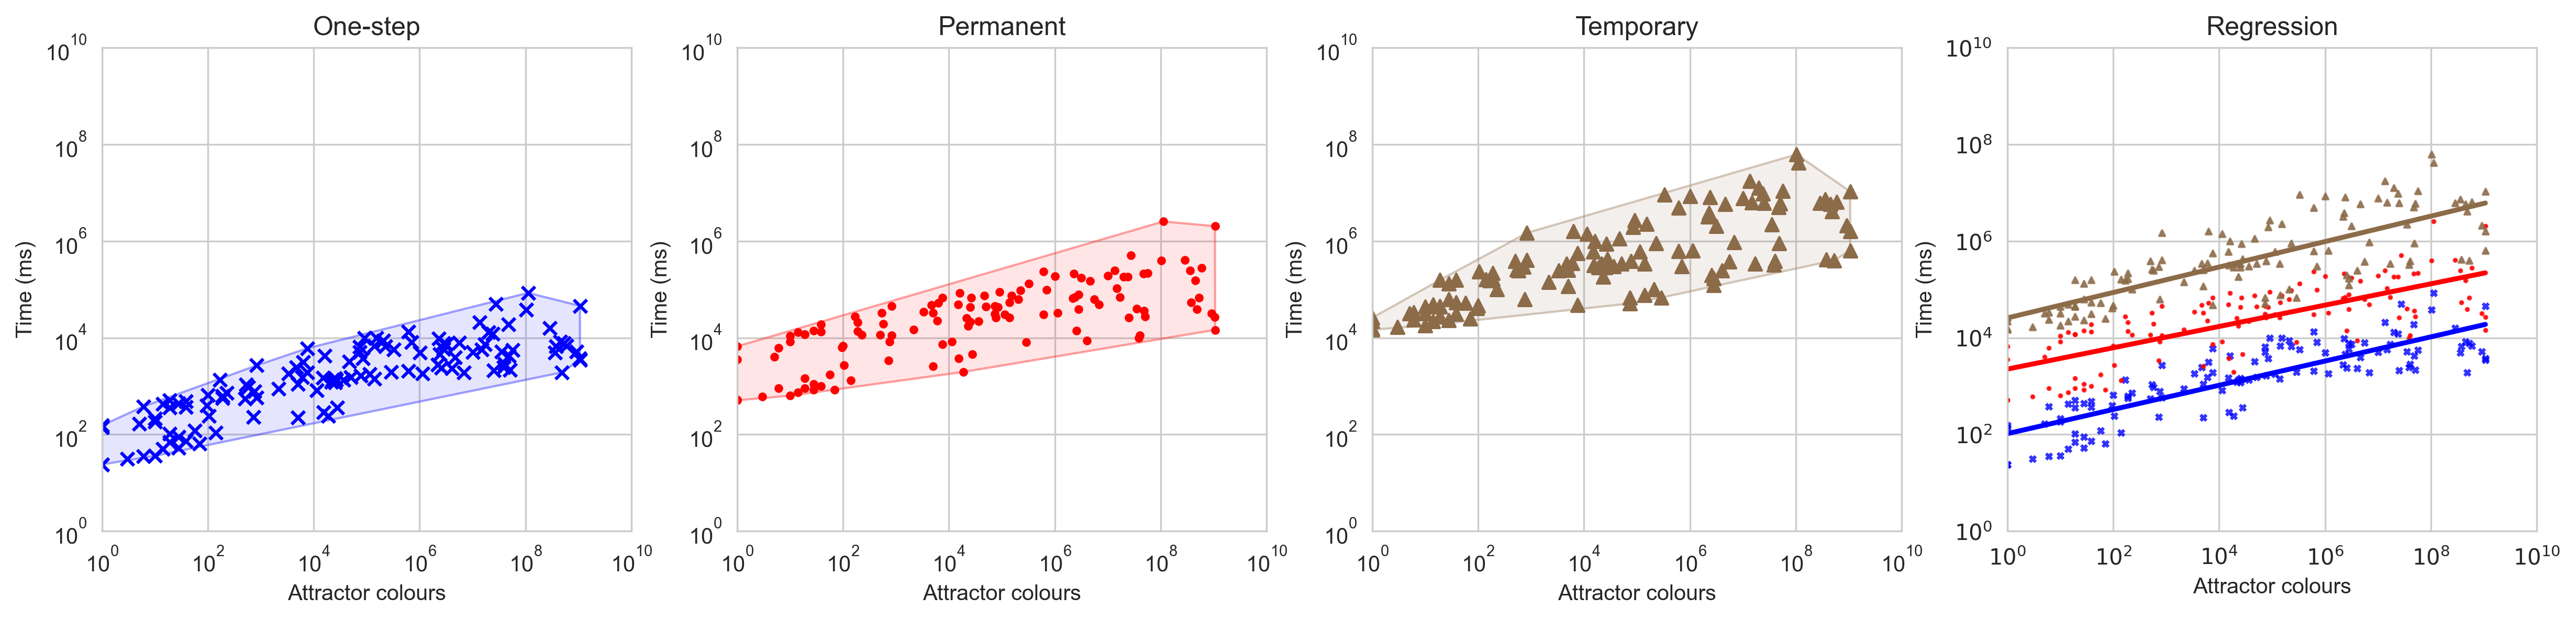

In [129]:

for model in ALL_MODELS:
    x_lim = 10 ** 10
    y_lim = 10 ** 10

    fig, axs = plt.subplots(1, 4)

    for i in range(len(ALL_METHOD_COLS)):
        generate_hull_plot(model, ALL_METHOD_COLS[i], ALL_METHODS_COLOURS[i],ALL_METHODS_MARKERS[i], x_lim, y_lim, axs[i])

    axs[3].set_title("Regression")
    axs[3].set_ylim(0, math.log(y_lim, 10))
    axs[3].set_xlim(0, math.log(x_lim, 10))
    axs[3].set_xlabel('Attractor colours')
    axs[3].set_ylabel('Time (ms)')

    for i in range(len(ALL_METHOD_COLS)):
        x, y = generate_log_scatter(model, ALL_METHOD_COLS[i])
        sns.regplot(x=x, y=y, color=ALL_METHODS_COLOURS[i], marker=ALL_METHODS_MARKERS[i], ci=None, scatter_kws={"s": 7}, ax=axs[3])

    new_labels = [f"10^{item.get_text()}" for item in axs[3].get_xticklabels()]
    ticks = range(0, 11, 2)
    axs[3].set_xticks([float(t) for t in ticks], [f'$10^{{{t}}}$' for t in ticks])
    axs[3].set_yticks([float(t) for t in ticks], [f'$10^{{{t}}}$' for t in ticks])

    fig.set_size_inches(20, 4)
    fig.set_dpi(300)

In [76]:
[str(math.pow(10, i)) for i in range(0, 9, 2)]

['1.0', '100.0', '10000.0', '1000000.0', '100000000.0']

In [12]:
data = pd.concat([generate_labelled_log_scatter(MYELOID, ALL_METHOD_COLS[i]) for i in range(len(ALL_METHOD_COLS))], axis=0, ignore_index=True)

print(data)

     Attractor colors  Time (ms)      label
0            0.477121   0.000000   One-step
1            0.477121   0.000000   One-step
2            0.477121   0.000000   One-step
3            0.477121   0.000000   One-step
4            0.698970   0.301030   One-step
..                ...        ...        ...
341          8.569069   4.404714  Temporary
342          8.672710   3.546419  Temporary
343          8.705962   4.119157  Temporary
344          8.854520   5.216741  Temporary
345          8.970470   3.694693  Temporary

[346 rows x 3 columns]


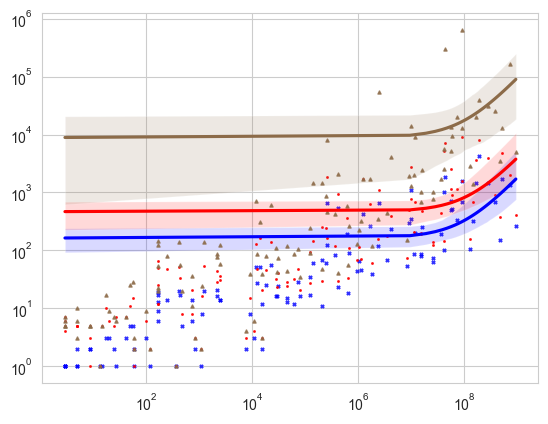

In [99]:
for i in range(len(ALL_METHOD_COLS)):
    x, y = generate_scatter(MYELOID, ALL_METHOD_COLS[i])
    ax = sns.regplot(x=x, y=y, color=ALL_METHODS_COLOURS[i], marker=ALL_METHODS_MARKERS[i], ci=95, scatter_kws={"s": 5})
    ax.set_yscale('log')
    ax.set_xscale('log')

In [27]:
def get_points(model_path, method):
    full_results_df = pd.read_csv(model_path)
    points_np = np.array(full_results_df[[ATT_COLORS_COL, method]].to_numpy())
    return points_np